# Load DeepFly3D Data

In [23]:
%load_ext autoreload
%autoreload 2
from load import *
import torch
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
from liftpose.vision_3d import world_to_camera_dict, reprojection_error, intrinsic_matrix
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)
from tqdm import tqdm
tqdm.get_lock().locks = []

# decleare data parameters
par_train = {  'data_dir'       : '/data/LiftPose3D/fly_tether/data_DF3D', # change the path 
               'out_dir'        : '/data/LiftPose3D/fly_tether/angle_inv_network',
               'train_subjects' : [1,2,3,4,5,6,7],
               'test_subjects'  : [6,7],
               'actions'        : ['all'],
               'cam_id'         : [0,6]}

#intr = intrinsic_matrix(171.0 * 94.0, 171.0 * 94.0, 240, 480) 
#intr = {0: intr,1: intr}
#tvec = {0: np.array([0, 0, 117]), 1: np.array([0, 0, 117])}

#narrow
#training_kwargs = {'eangles': {0: [[-30,-20], [-2, 2], [-2,2]], 1: [[-270,-250], [-2, 2], [-2,2]]},
#                   'axsorder': 'yxz',
#                   'vis': {0: [1 if i<15 else 0 for i in range(30)], 1: [0 if i<15 else 1 for i in range(30)]},
#                   'tvec': None,
#                   'intr': None}
#wide
training_kwargs = {'eangles':  {0: [[-225,-45], [-2, 2], [-2,2]], 1: [[-45,135], [-2, 2], [-2,2]]},
                   'axsorder': 'yxz',
                   'vis': {0: [1 if i<15 else 0 for i in range(30)], 1: [0 if i<15 else 1 for i in range(30)]},
                   'tvec': None,
                   'intr': None}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# Load 2D data
test_2d = load_2D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["test_subjects"],
    actions=par["actions"],
)

# Load 3D data
train_3d, train_keypts, rcams_train = load_3D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["train_subjects"],
    actions=par["actions"],
)
test_3d, test_keypts, rcams_test = load_3D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["test_subjects"],
    actions=par["actions"],
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Train LiftPose3D Network on DeepFly3D Data

In [3]:
from liftpose.preprocess import obtain_projected_stats
    
stats = obtain_projected_stats(train_3d,
                               training_kwargs['eangles'], 
                               training_kwargs['axsorder'], 
                               training_kwargs['vis'],
                               training_kwargs['tvec'],
                               training_kwargs['intr'],
                               par['roots'], 
                               par['target_sets'],
                               par['out_dir'],
                               load_existing=True,
                               th=1)

[preprocess.py:444]:INFO:Bootstrapping mean and variance...
[preprocess.py:448]:INFO:Loaded existing data.


In [24]:
from liftpose.main import train as lp3d_train
from liftpose.lifter.augmentation import random_project

aug = random_project(**training_kwargs)

lp3d_train(train_2d=None, test_2d=test_2d,
           train_3d=train_3d, test_3d=test_3d, 
           train_keypts=train_keypts,
           test_keypts=test_keypts,
           roots=par['roots'],
           target_sets=par['target_sets'],
           out_dir=par['out_dir'],
           training_kwargs={"resume":True,
                            "load": par['out_dir'] + '/ckpt_best.pth.tar',
                            "epochs":20},
           augmentation=[aug],
           stats=stats)

[main.py:250]:INFO:Saving pre-processed 2D data at /data/LiftPose3D/fly_tether/angle_inv_network/stat_2d.pth.tar.
[main.py:269]:INFO:Saving pre-processed 3D data at /data/LiftPose3D/fly_tether/angle_inv_network/stat_3d.pth.tar.
[main.py:297]:INFO:Starting training model.
[main.py:307]:DEBUG:
==================Options=================
[main.py:308]:DEBUG:{   'batch_size': 64,
    'data_dir': '/data/LiftPose3D/fly_tether/angle_inv_network',
    'dropout': 0.5,
    'epochs': 20,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': '/data/LiftPose3D/fly_tether/angle_inv_network/ckpt_best.pth.tar',
    'lr': 0.001,
    'lr_decay': 5000,
    'lr_gamma': 0.9,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/data/LiftPose3D/fly_tether/angle_inv_network',
    'out_dir': '/data/LiftPose3D/fly_tether/angle_inv_network',
    'predict': False,
    'procrustes': False,
    'resume': True,
    'test': False}
[main.py:309]:DEBUG:=============

Epoch 010 | LR  0.00009 | Loss Test  0.00000 | Loss Train  0.09373|:  16%|█▌        | 1843/11644 [00:14<01:18, 124.41it/s]


KeyboardInterrupt: 

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


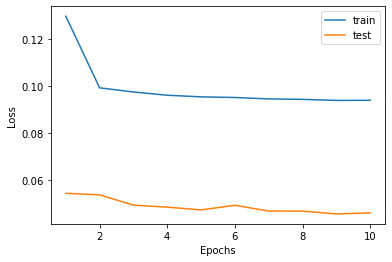

In [5]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

# Run Trained LiftPose3D Network on the Test Data

In [6]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

[main.py:397]:INFO:starting testing in path: /data/LiftPose3D/fly_tether/angle_inv_network
[lift.py:31]:INFO:Training on the device: cuda:0
[lift.py:53]:INFO:total params: 4.33M
[lift.py:61]:INFO:loading ckpt from '/data/LiftPose3D/fly_tether/angle_inv_network/ckpt_best.pth.tar'
[lift.py:69]:INFO:ckpt loaded (epoch: 10 | err: 0.35896703177059025)
[lift.py:103]:INFO:Saving results: /data/LiftPose3D/fly_tether/angle_inv_network/test_results.pth.tar


# Visualize Predictions

In [7]:
from liftpose.postprocess import load_test_results
data = torch.load(os.path.join(par['out_dir'], "test_results.pth.tar"))
stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)
test_3d_gt, test_3d_pred, good_keypts = load_test_results(data, stat_2d, stat_3d)

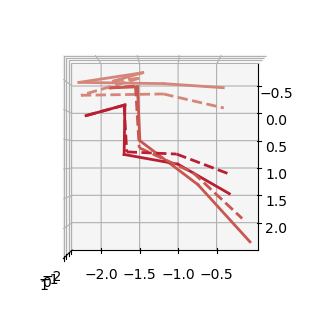

In [13]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
#%matplotlib widget
%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=90, azim=0)

t = 500
plot_pose_3d(ax=ax, tar=test_3d_gt[t], 
            pred=test_3d_pred[t], 
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            good_keypts=good_keypts[t],
            show_gt_always=False)